In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.offline as pyo
import plotly.graph_objs as go
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import gc

from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials
import matplotlib.pyplot as plt
import csv
from lightgbm import LGBMClassifier
import os
import pickle
from sklearn.model_selection import StratifiedKFold
import ast

%matplotlib inline

In [2]:
df_data = pd.read_csv("data/response_data.csv")

In [3]:
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_new,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


- **recency:** months since last purchase
- **history:** $ value of the historical purchases
- **used_discount/used_bogo:** indicates if the customer used a discount or buy get one before
- **zip_code:** class of the zip code as Suburban/Urban/Rural
- **is_new:** indicates if the customer new
- **channel:** channels that the customer using, Phone/Web/Multichannel
- **offer:** the offers sent to the customers, Discount/But One Get One/No Offer
- **conversion:** Customer purchased something in the following two weeks

**Uplift Formula**

- **Conversion Uplift:** Conversion rate of test group - conversion rate of control group
    - What % increase of customers were converted by sending out offers

- **Order Uplift:** Conversion uplift * number of converted customers in test group
    - How many customers is this % increase equivalent to

- **Revenue Uplift:** Order Uplift * Average order value
    - How much extra money does this group of converted customers generate

In [4]:
def calc_uplift(df):
    #assigning 25$ to the average order value
    avg_order_value = 25
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
          
    print('-------------- \n')
    print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
    print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
    print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))

In [5]:
calc_uplift(df_data)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


# EDA

**Recency vs Conversion Rate**

We expect the active customers to be converted more frequently since conversion is measured within a 2 week period.

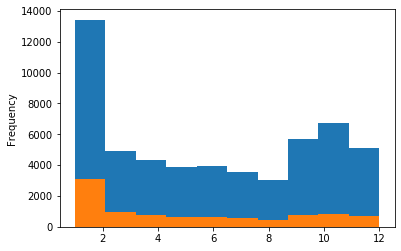

In [6]:
df_data[df_data.conversion==0].recency.plot.hist()
df_data[df_data.conversion==1].recency.plot.hist();

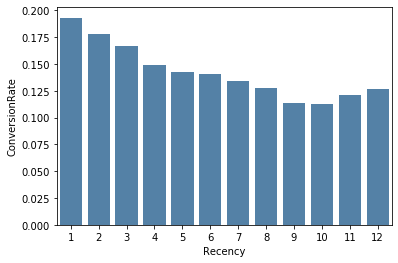

In [7]:
df = df_data.groupby("recency")['conversion'].mean().reset_index()
df.columns = ['Recency', 'ConversionRate']
sns.barplot(x='Recency', y='ConversionRate', data=df, color='steelblue')

Trend is as expected until the 11 month period where conversion rate begins to increase. From the histogram it can be seen that there is a spike in customers who have a recency of >9 months which may be causing the change in the trend.

In [8]:
del df
gc.enable()
gc.collect()

3785

<br>
<br>

**History vs Conversion rate**

In [9]:
# Use elbow method to select the correct number of clusters

#inertias = []
#for n in range(1,10):
#    kmeans = KMeans(n_clusters=n, n_init=30)
#    kmeans.fit(df_data.history.values.reshape(-1,1))
#    inertias.append(kmeans.inertia_)
#    
#plt.plot(list(range(1,10)), inertias);

In [10]:
kmeans = KMeans(n_clusters=5, n_init=30)
kmeans.fit(df_data.history.values.reshape(-1,1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [11]:
df_data['HistoryClusters'] = kmeans.labels_
# idx of "remap" = New label
remap = np.array(sorted(zip(kmeans.cluster_centers_.reshape(-1).tolist(), range(0,5)), key=lambda x: x[0]))[:,1]
remapper = {}
for idx, i in enumerate(remap):
    remapper[int(i)] = idx
df_data['HistoryClusters'].replace(remapper, inplace=True)

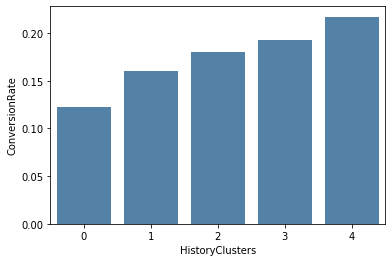

In [12]:
df = df_data.groupby("HistoryClusters")['conversion'].mean().reset_index()
df.columns = ['HistoryClusters', 'ConversionRate']
sns.barplot(x='HistoryClusters', y='ConversionRate', data=df, color='steelblue');

In [13]:
del remap, remapper, df
gc.enable()
gc.collect()

2782

The more the customer spent in the last year, the more likely they are to be converted by an offer. This agrees with our recency hypothesis whereby history is proportional to how active a customer is and active customers are more likely to be converted (here activity is measured by how much a customer spent in the last year).

<br>
<br>

**Used discount & BOGO**

In [14]:
# Use "agg" to return a df instead of a series
df_data.groupby(["used_discount", "used_bogo", "offer"]).agg({'conversion':'mean'})

conversion
used_discount used_bogo offer                      
0             1         Buy One Get One    0.169794
                        Discount           0.166388
                        No Offer           0.095808
1             0         Buy One Get One    0.110892
                        Discount           0.168968
                        No Offer           0.099813
              1         Buy One Get One    0.251653
                        Discount           0.314993
                        No Offer           0.180549

Customers who used both of the offers before have the highest conversion rate.

<br>
<br>

**Zip code**

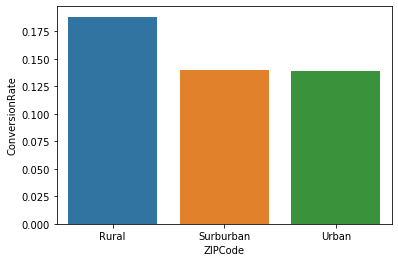

In [15]:
df = df_data.groupby("zip_code")['conversion'].mean().reset_index()
df.columns = ['ZIPCode', 'ConversionRate']
sns.barplot(x='ZIPCode', y='ConversionRate', data=df)

In [16]:
del df
gc.enable()
gc.collect()

35

<br>
<br>

**New customers**

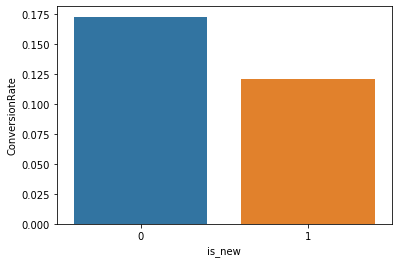

In [17]:
df = df_data.groupby("is_new")['conversion'].mean().reset_index()
df.columns = ['is_new', 'ConversionRate']
sns.barplot(x='is_new', y='ConversionRate', data=df)

In [18]:
del df
gc.enable()
gc.collect()

35

<br>
<br>

**Channel**

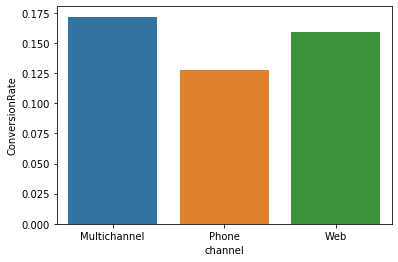

In [19]:
df = df_data.groupby("channel")['conversion'].mean().reset_index()
df.columns = ['channel', 'ConversionRate']
sns.barplot(x='channel', y='ConversionRate', data=df)

In [20]:
del df
gc.enable()
gc.collect()

35

<br>
<br>

**Offer Type**

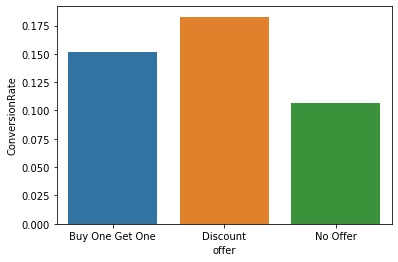

In [21]:
df = df_data.groupby("offer")['conversion'].mean().reset_index()
df.columns = ['offer', 'ConversionRate']
sns.barplot(x='offer', y='ConversionRate', data=df)

In [22]:
del df
gc.enable()
gc.collect()

35

<br>
<br>

**Build model**

In [23]:
train = df_data.copy()
label = train.conversion.values
train = train.drop(columns="conversion")
train = pd.get_dummies(train).values

In [24]:
log_regr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)

In [25]:
log_regr.fit(train, label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
log_regr.predict_proba(train)

array([[0.89696532, 0.10303468],
       [0.81400188, 0.18599812],
       [0.87973064, 0.12026936],
       ...,
       [0.90888991, 0.09111009],
       [0.86757106, 0.13242894],
       [0.68183775, 0.31816225]])

<br>
<br>

In [27]:
train_df = df_data.copy()
label_df = train_df.conversion
train_df = train_df.drop(columns="conversion")

le_maps = {}
for col in train_df.select_dtypes("object"):
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    train_df[col] = train_df[col].astype("category")
    le_maps[col] = le.classes_
    
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(train_df, label_df, test_size=0.1, random_state=42)
X_train_df, X_test_df, y_train_df, y_test_df = X_train_df.copy(), X_test_df.copy(), y_train_df.copy(), y_test_df.copy()
y_train_df = pd.DataFrame(y_train_df)
y_test_df = pd.DataFrame(y_test_df)

In [28]:
train = X_train_df.copy()
label = y_train_df.copy()

N_FOLDS = 5

def objective(params, n_folds=N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name]) 
    
    # Use GPU
    params['device'] = 'gpu'
    
    skf = StratifiedKFold(N_FOLDS)
    cv_n_estimators = []
    cv_scores = []
    
    start = timer()
    
    for train_index, val_index in skf.split(train, label):
        X_train, y_train = train.iloc[train_index,:], label.iloc[train_index, 0].values
        X_val, y_val = train.iloc[val_index,:], label.iloc[val_index, 0].values
        
        model = LGBMClassifier(**params, n_jobs=6, random_state=30)
        model.fit(X_train, y_train, 
                  eval_metric='binary_logloss',
                  eval_set = [(X_val, y_val)],
                  eval_names = ['valid'], 
                  categorical_feature = 'auto',
                  early_stopping_rounds = 100,
                  verbose=0
                 )
        cv_n_estimators.append(model.best_iteration_)
        cv_scores.append(model.best_score_['valid']['binary_logloss'])
    
    run_time = timer() - start
    
    best_score = np.mean(cv_scores)
    loss = best_score
    n_estimators = np.mean(cv_n_estimators)
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    gc.enable()
    gc.collect()
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [29]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)},
                                                 #{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 5, 300, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 1000, 50000, 1000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 250, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.3, 1.0)
}

# optimization algorithm
tpe_algorithm = tpe.suggest

######################################### Keep track of results #########################################################

# Fresh start
bayes_trials = Trials()

# Warm start
#bayes_trials = pickle.load(open("bayes_trials_200.p", "rb"))

####################################### File to save first results #########################################################

# ONLY RUN THIS ON SUBSEQUENT TIMES
#out_file = 'results/gbm_trials.csv'

# RUN THIS ON FIRST TIME
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [30]:
from hyperopt import fmin

# Global variable
global ITERATION

MAX_EVALS = 100
ITERATION = 0

# Run optimization
best = fmin(fn = objective, 
            space = space, 
            algo = tpe.suggest, 
            max_evals = MAX_EVALS, 
            trials = bayes_trials, 
            rstate = np.random.RandomState(30)
           )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:31<00:00,  9.92s/it, best loss: 0.39902836052045154]


<br>
<br>

In [31]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)

# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
best_bayes_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.5952681206633422,
 'learning_rate': 0.386755523992913,
 'min_child_samples': 107,
 'num_leaves': 5,
 'reg_alpha': 0.2427335671046913,
 'reg_lambda': 0.1507696835258036,
 'subsample_for_bin': 29000,
 'subsample': 0.7325353214056809,
 'device': 'gpu'}

In [32]:
best_bayes_model = LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = 6, random_state = 30, **best_bayes_params)
best_bayes_model.fit(train, label.conversion.values, eval_metric='binary_logloss', categorical_feature = 'auto')

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5952681206633422, device='gpu',
               importance_type='split', learning_rate=0.386755523992913,
               max_depth=-1, min_child_samples=107, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=31, n_jobs=6, num_leaves=5,
               objective=None, random_state=30, reg_alpha=0.2427335671046913,
               reg_lambda=0.1507696835258036, silent=True,
               subsample=0.7325353214056809, subsample_for_bin=29000,
               subsample_freq=0)

In [33]:
X_test_df['proba'] = best_bayes_model.predict_proba(X_test_df)[:,1]
X_test_df['conversion'] = y_test_df.values

In [34]:
import pickle
pickle.dump(bayes_trials, open("bayes_trials_100.p", "wb"))

In [35]:
from sklearn.externals import joblib
# save model
joblib.dump(best_bayes_model, 'lgb_100.pkl')

# load model
#best_bayes_model = joblib.load('lgb.pkl')

c:\users\wongt\desktop\market_response_models\mrm_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



['lgb_100.pkl']

<br>
<br>

In [36]:
le_maps

{'zip_code': array(['Rural', 'Surburban', 'Urban'], dtype=object),
 'channel': array(['Multichannel', 'Phone', 'Web'], dtype=object),
 'offer': array(['Buy One Get One', 'Discount', 'No Offer'], dtype=object)}

In [37]:
print(len(X_test_df) * (X_test_df[X_test_df.offer == 1].conversion.mean() - X_test_df[X_test_df.offer == 2].conversion.mean()))
print(len(X_test_df) * (X_test_df[X_test_df.offer == 1].proba.mean() - X_test_df[X_test_df.offer == 2].proba.mean()))

457.08575612697587
491.98975391879196


In [38]:
print(len(X_test_df) * (X_test_df[X_test_df.offer == 0].conversion.mean() - X_test_df[X_test_df.offer == 2].conversion.mean()))
print(len(X_test_df) * (X_test_df[X_test_df.offer == 0].proba.mean() - X_test_df[X_test_df.offer == 2].proba.mean()))

300.8432733562459
293.3267708080441


<br>
<br>

The model is able to predict moderately well the Order uplift for borth discount and bogo offers (with the model performing better for bogo offers in this particular Train-Test split).